In [1]:
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

import os
from pathlib import Path

import numpy as np
import pandas as pd 

import cv2

# Load data

In [2]:
def load_images_from_directory(dir_):
    images = tf.keras.preprocessing.image_dataset_from_directory(
        dir_,
        image_size=(128, 128),
        shuffle=False
    )

    images, _ = zip(*images.unbatch())
    images = np.array(images)
    
    return images

images = load_images_from_directory('data/images').astype(np.uint8)
drill_maps = load_images_from_directory('data/maps').astype(np.uint8)[:, :, :, 0]

images.shape, drill_maps.shape

Found 3140 files belonging to 11 classes.
Found 3140 files belonging to 11 classes.


((3140, 128, 128, 3), (3140, 128, 128))

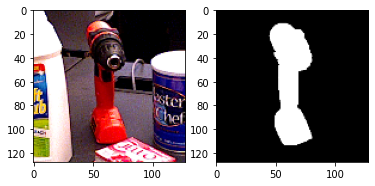

In [3]:
plt.subplot(1, 2, 1)
plt.imshow(images[0])
plt.subplot(1, 2, 2)
plt.imshow(drill_maps[0], cmap='gray')

# Canny

In [4]:
def apply_canny(src, ksize=7, sigma=1.2, low_th=10, high_th=70, apply_gray=True):
    if apply_gray:
        src = cv2.cvtColor(src, cv2.COLOR_RGB2GRAY)
    blur_gray = cv2.GaussianBlur(src,(ksize, ksize), sigma)
    dst = cv2.Canny(blur_gray, low_th, high_th)# // 255
    
    return dst

In [5]:
def plot_canny(image, apply_gray=True, sigma=1.2):
    canny = apply_canny(image, apply_gray=apply_gray, sigma=sigma)
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.subplot(1, 2, 2)
    plt.imshow(canny, cmap='gray')

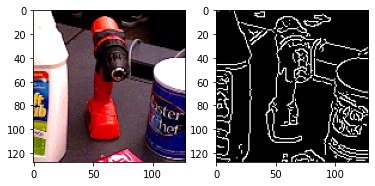

In [6]:
plot_canny(images[100])

# HED

In [7]:
# class CropLayer(object):
#     def __init__(self, params, blobs):
#         # initialize our starting and ending (x, y)-coordinates of
#         # the crop
#         self.startX = 0
#         self.startY = 0
#         self.endX = 0
#         self.endY = 0
        
# def getMemoryShapes(self, inputs):
#     # the crop layer will receive two inputs -- we need to crop
#     # the first input blob to match the shape of the second one,
#     # keeping the batch size and number of channels
#     (inputShape, targetShape) = (inputs[0], inputs[1])
#     (batchSize, numChannels) = (inputShape[0], inputShape[1])
#     (H, W) = (targetShape[2], targetShape[3])
#     # compute the starting and ending crop coordinates
#     self.startX = int((inputShape[3] - targetShape[3]) / 2)
#     self.startY = int((inputShape[2] - targetShape[2]) / 2)
#     self.endX = self.startX + W
#     self.endY = self.startY + H
#     # return the shape of the volume (we'll perform the actual
#     # crop during the forward pass
#     return [[batchSize, numChannels, H, W]]
        
hed_net = cv2.dnn.readNetFromCaffe("deploy.prototxt", "hed_pretrained_bsds.caffemodel")
# cv2.dnn_registerLayer("Crop", CropLayer)

In [8]:
def apply_hed(image):
    image = np.array(tf.keras.layers.UpSampling2D((4, 4))(np.array([image])))[0]
    (H, W) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(image, scalefactor=1.0, size=(W, H), swapRB=False, crop=False)
    # net = cv2.dnn.readNetFromCaffe("deploy.prototxt", "hed_pretrained_bsds.caffemodel")
    hed_net.setInput(blob)
    hed = hed_net.forward()
    hed = cv2.resize(hed[0, 0], (W, H))
    return hed

In [9]:
def plot_hed(image):
    (H, W) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(image, scalefactor=1.0, size=(W, H), swapRB=False, crop=False)
    # net = cv2.dnn.readNetFromCaffe("deploy.prototxt", "hed_pretrained_bsds.caffemodel")
    hed_net.setInput(blob)
    hed = hed_net.forward()
    hed = cv2.resize(hed[0, 0], (W, H))
    # hed = hed.astype("uint8")


    # img_org_2 = 255-hed
    # _, img_org_2 = cv2.threshold(img_org_2, 40, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    # img_org_2_dist = cv2.distanceTransform(img_org_2.astype(np.uint8), cv2.DIST_L2, 3)
    # fig, (ax1, ax2) = plt.subplots(1, 2)
    # ax1.imshow(img_org_2_dist)
    # ax1.set_title('HED')
    # cv2.imshow("HED_DT", img_org_dist)

    # cv2.imshow("HED", hed)
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.subplot(1, 2, 2)
    plt.imshow(hed, cmap='gray')
    
    plt.show()

In [10]:
hed_images = np.array(tf.keras.layers.UpSampling2D((4, 4))(images[:1000]))

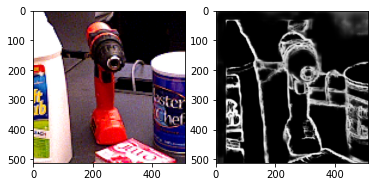

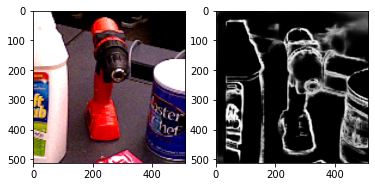

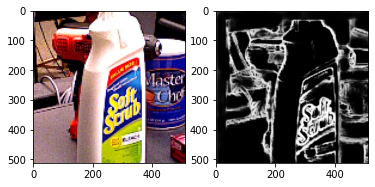

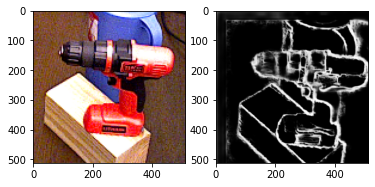

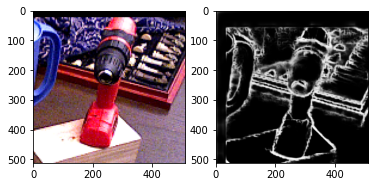

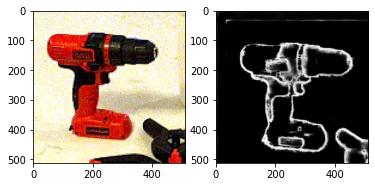

In [11]:
for idx in [0, 100, 200, 300, 450, 900]:
    plot_hed(hed_images[idx])

# u-net

In [12]:
from u_net_model import create_unet_128

## Convert drill maps to heatmaps of edges

In [13]:
def prepare_heatmap(image, ksize=15, sigma=1.8):
    image = apply_canny(image, apply_gray=False)
    image = cv2.GaussianBlur(image, (ksize, ksize), sigma)
    image = image.astype('float')
    image /= image.max()
    image *= 255.
    return image.astype(np.uint8)

edges_heatmaps = [prepare_heatmap(drill_map) for drill_map in drill_maps]
edges_heatmaps = np.array(edges_heatmaps)

edges_heatmaps.shape

(3140, 128, 128)

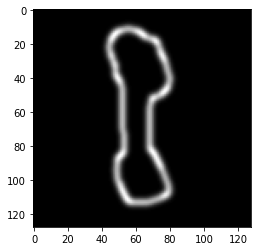

In [14]:
plt.imshow(edges_heatmaps[0], cmap='gray')

## Train

In [15]:
from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(images / 255. , edges_heatmaps / 255., test_size=0.2, random_state=42)

X_train, X_test = images[:-320] / 255., images[-320:] / 255.
y_train, y_test = edges_heatmaps[:-320] / 255., edges_heatmaps[-320:] / 255.

input_size, model = create_unet_128()

cp_callback_best = tf.keras.callbacks.ModelCheckpoint(filepath='./model_checkpoints/best', save_weights_only=True, save_best_only=True, verbose=1)
cp_callback_last = tf.keras.callbacks.ModelCheckpoint(filepath='./model_checkpoints/last', save_weights_only=True, save_best_only=False, verbose=1)

# history = model.fit(X_train, y_train, batch_size=32, validation_data=(X_test, y_test), verbose=1, epochs=50, callbacks=[cp_callback_best, cp_callback_last])

C:\Users\MatiX\anaconda3\envs\py39\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/50
89/89 [==============================] - ETA: 0s - loss: 0.9748 - dice_loss: 0.2794
Epoch 1: val_loss improved from inf to 2.01621, saving model to ./model_checkpoints\best

Epoch 1: saving model to ./model_checkpoints\last
89/89 [==============================] - 36s 292ms/step - loss: 0.9748 - dice_loss: 0.2794 - val_loss: 2.0162 - val_dice_loss: 4.7542e-05
Epoch 2/50
89/89 [==============================] - ETA: 0s - loss: 0.7047 - dice_loss: 0.4684
Epoch 2: val_loss improved from 2.01621 to 1.94271, saving model to ./model_checkpoints\best

Epoch 2: saving model to ./model_checkpoints\last
89/89 [==============================] - 22s 244ms/step - loss: 0.7047 - dice_loss: 0.4684 - val_loss: 1.9427 - val_dice_loss: 0.0012
Epoch 3/50
89/89 [==============================] - ETA: 0s - loss: 0.6176 - dice_loss: 0.5373
Epoch 3: val_loss improved from 1.94271 to 1.49595, saving model to ./model_checkpoints\best

Epoch 3: saving model to ./model_checkpoints\last
89/89 [========

In [18]:
model.load_weights('./model_checkpoints/best')
print('train')
model.evaluate(X_train, y_train, batch_size=32, verbose=1)
print('test')
model.evaluate(X_test, y_test, batch_size=32, verbose=1)
None

train
89/89 [==============================] - 6s 62ms/step - loss: 0.6263 - dice_loss: 0.5428
test
10/10 [==============================] - 1s 63ms/step - loss: 0.8882 - dice_loss: 0.3886


## Evaluate

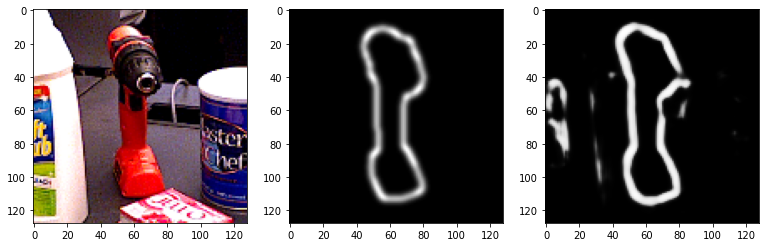

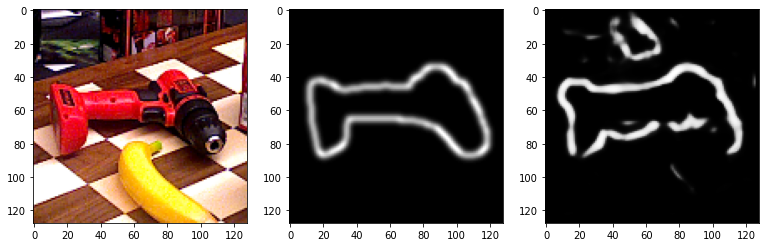

In [19]:
def plot_unet(image, edges):
    plt.figure(figsize=(13, 4))
    pred_edges = model.predict(np.array([image]))[0]
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.subplot(1, 3, 2)
    plt.imshow(edges, cmap='gray')
    plt.subplot(1, 3, 3)
    plt.imshow(pred_edges, cmap='gray')
    
plot_unet(X_train[0], y_train[0])
plot_unet(X_test[0], y_test[0])

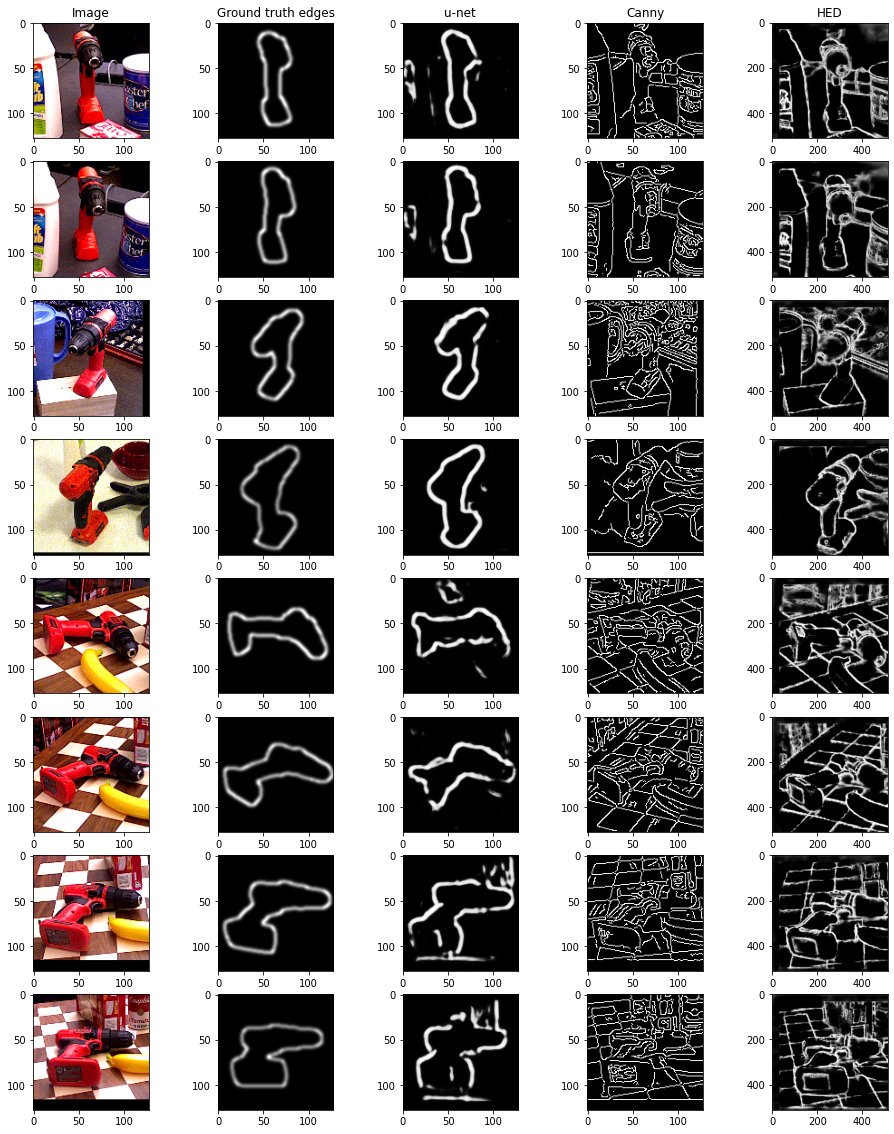

In [20]:
def plot_images(images, edges):
    plt.figure(figsize=(16, 20))
    n = len(images)
    for i, (image, edge) in enumerate(zip(images, edges)):
        plt.subplot(n, 5, 1 + i * 5)
        plt.imshow(image)
        if i == 0:
            plt.title('Image')
        
        plt.subplot(n, 5, 2 + i * 5)
        plt.imshow(edge, cmap='gray')
        if i == 0:
            plt.title('Ground truth edges')
        
        pred_edges = model.predict(np.array([image / 255.]))[0]
        plt.subplot(n, 5, 3 + i * 5)
        plt.imshow(pred_edges, cmap='gray')
        if i == 0:
            plt.title('u-net')
        
        canny = apply_canny(image)
        plt.subplot(n, 5, 4 + i * 5)
        plt.imshow(canny, cmap='gray')
        if i == 0:
            plt.title('Canny')
            
        hed = apply_hed(image)
        plt.subplot(n, 5, 5 + i * 5)
        plt.imshow(hed, cmap='gray')
        if i == 0:
            plt.title('HED')
            
indices = [0, 100, 400, 1000, -300, -200, -100, -10]

images_to_plot = [images[idx] for idx in indices]
edges_images_to_plot = [edges_heatmaps[idx] for idx in indices]

plot_images(images_to_plot, edges_images_to_plot)